In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from skimage.feature import hog
import glob
import matplotlib.image as mpimg
import cv2
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import accuracy_score

%matplotlib inline


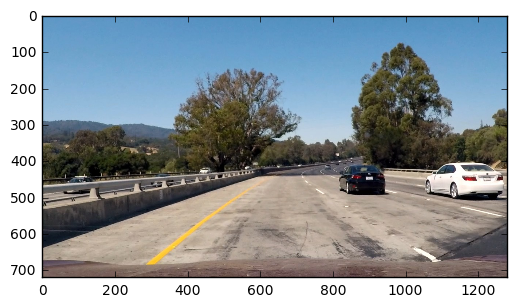

In [2]:
test_image = mpimg.imread("test_images/test1.jpg")
plt.imshow(test_image)

In [118]:
car_images = glob.glob('vehicles/**/*.png')
non_car_images = glob.glob('non-vehicles/**/*.png')
print(len(car_images), len(non_car_images))

8792 8968


In [5]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Adding the HOG Features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features



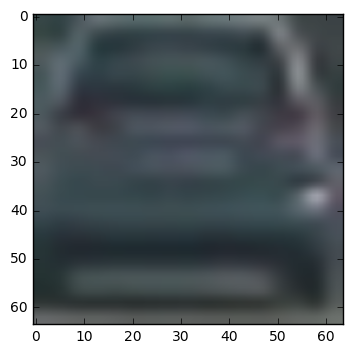

In [120]:
testing = mpimg.imread(car_images[10])
plt.imshow(testing)

In [8]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=11, pix_per_cell=16, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        #Put back bin_spatial and color_hist HERE if want
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [116]:
from sklearn.preprocessing import StandardScaler
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

#Extracting car and non car features on the images 
car_features = extract_features(car_images, cspace= colorspace, hog_channel=hog_channel)
non_car_features = extract_features(non_car_images, cspace= colorspace, hog_channel=hog_channel)

features_data = np.vstack((car_features, non_car_features)).astype(np.float64)
print(len(features_data))
# X_scaler = StandardScaler().fit(features_data)
# scaled_X = X_scaler.transform(features_data)
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))



17760


In [42]:
random.shuffle(features_data)
X_train, X_test, y_train, y_test = train_test_split(features_data, labels, test_size=0.2, random_state = np.random.randint(0, 100))


In [43]:
#Training Classifier Here
svc = LinearSVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.981137387387


In [44]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    shapes = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #Don't be lazy, test all of them 
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell            
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                shapes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return shapes

In [102]:
ystart = 400
ystop = 656
scale = 1.5
#Try all of the colorspaces, don't be lazy 
colorspace = 'YUV' 
hog_channel = 'ALL' 

shapes = find_cars(np.copy(test_image), ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print("Shapes Found:", len(shapes))

Shapes Found: 2


In [54]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [56]:
# Adding the heat maps 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

In [57]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [58]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

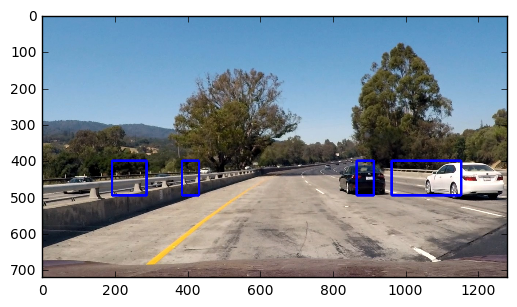

In [104]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

add_heat(heat, shapes)

heat = apply_threshold(heat,1)

heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

plt.imshow(draw_img)

In [91]:
def process_frame(img):

    shapes = []

    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' 
    
    #Cars Farther out
    ystart = 400
    ystop = 460
    scale = 1.0
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    ystart = 420
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    #Cars in the Middle
    ystart = 400
    ystop = 500
    scale = 1.5
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 430
    ystop = 530
    scale = 1.5
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
   
    ystart = 400
    ystop = 530
    scale = 2.0
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 430
    ystop = 560
    scale = 2.0
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    
    #Cars Closest to the Screen
    ystart = 400
    ystop = 600
    scale = 3.5
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))
    ystart = 460
    ystop = 660
    scale = 3.5
    shapes.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None))

    shapes = [item for sublist in shapes for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, shapes)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [92]:
from moviepy.editor import *
output_video = "projectvideo_output.mp4"
clip1 = VideoFileClip("project_video.mp4").subclip()
output_clip = clip1.fl_image(process_frame)
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video projectvideo_output.mp4
[MoviePy] Writing video projectvideo_output.mp4


100%|█████████▉| 1260/1261 [04:52<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: projectvideo_output.mp4 

CPU times: user 4min 10s, sys: 47.6 s, total: 4min 57s
Wall time: 4min 53s


In [93]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))